### Import libraries

In [1]:
import os
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from itertools import combinations
from netCDF4 import Dataset
from sys import getsizeof
from math import sqrt

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

%matplotlib inline

## TODOs

- [x] Try to normalize the data for clustering
- [x] Normalize and abstract dataset for 15min per sample
- [x] Save clusters to a csv file
- [x] Create a TimeseriesGenerator with 24h history
- [x] build the LSTM blackbox model
- [x] evaluate the LSTM model rmse error
- [ ] build the RNN blackbox model
- [ ] evaluate the RNN model rmse error

## ISSUES
- In Winter, we don't have data from december 2016  

### Remarks
- List of variables: (*id; time; Stat; Event; Schedule; Indoor_AverageTemperature; Indoor_CoolSetpoint; Indoor_HeatSetpoint; Indoor_Humidity; HeatingEquipmentStage1_RunTime; HeatingEquipmentStage2_RunTime; HeatingEquipmentStage3_RunTime; CoolingEquipmentStage1_RunTime; CoolingEquipmentStage2_RunTime; HeatPumpsStage1_RunTime; HeatPumpsStage2_RunTime; Fan_RunTime; Thermostat_Temperature; Thermostat_DetectedMotion; RemoteSensor1_Temperature; RemoteSensor1_DetectedMotion; RemoteSensor2_Temperature; RemoteSensor2_DetectedMotion; RemoteSensor3_Temperature; RemoteSensor3_DetectedMotion; RemoteSensor4_Temperature; RemoteSensor4_DetectedMotion; RemoteSensor5_Temperature; RemoteSensor5_DetectedMotion; Outdoor_Temperature; Outdoor_Humidity; HVAC_Mode*)
- Most variables are unitless
- Seasons:
    - Spring: March, April, May
    - Summer: June, July, August
    - Autumn: September, October, November
    - Winter: December, January, February



### Configurations

In [2]:
plt.rcParams["figure.figsize"] = (10,5)
plt.rcParams['figure.dpi'] = 300

### Constants

In [3]:
DATA_DIR = "data/ecobee/"
CLUSTERS_DIR = "data/ecobee/clusters"
META_CLUSTER_COLUMNS = ['Identifier','Floor Area [ft2]', 'Age of Home [years]']
META_SIM_COLUMNS = ['Identifier','Floor Area [ft2]', 'Number of Floors', 'Age of Home [years]']
DF_CLUSTER_IDX = ['in_cool', 'in_heat', 'in_hum', 'out_hum', 'out_temp', 'in_temp']
TIME_ABSTRACTION = "H" # None | "H" | 15min
WINTER = ['12', '01', '02']
SPRING = ['03', '04', '05']
SUMMER = ['06', '07', '08']
AUTUMN = ['09', '10', '11']

### Load dataset

In [4]:
#Load datasets

data = {}
for filename in os.listdir(DATA_DIR):
    if filename.endswith('.nc'):
        f = Dataset(os.path.join(DATA_DIR, filename), "r", format="NETCDF4")
        key = f.input_files.partition("2017")[2][:2]
        # for vname, v in f.variables.items():
        data[key] = {
            'id': f.variables['id'][:],
            'time': f.variables['time'][:],
            'state': f.variables['State'][:],
            'in_temp': f.variables['Indoor_AverageTemperature'][:],
            'in_cool': f.variables['Indoor_CoolSetpoint'][:],
            'in_heat': f.variables['Indoor_HeatSetpoint'][:],
            'in_hum': f.variables['Indoor_Humidity'][:],
            'out_temp': f.variables['Outdoor_Temperature'][:],
            'out_hum': f.variables['Outdoor_Humidity'][:],
            # 'mode': f.variables['HVAC_Mode'][:], # only a masked value: -9999 
        }
        f.close()

In [5]:
# features
list(data['01'].keys())

['id',
 'time',
 'state',
 'in_temp',
 'in_cool',
 'in_heat',
 'in_hum',
 'out_temp',
 'out_hum']

In [6]:
in_temp = data['06']['in_temp']
print(f"The temperature records for every 5min in a month ({in_temp.shape[1]} records) for {in_temp.shape[0]} houses")

The temperature records for every 5min in a month (8640 records) for 985 houses


### Select and clean summer season data

In [7]:
def get_cleaned_season(dataset, season=SUMMER):
    data = copy.deepcopy(dataset)
    assert len(season) == 3
    # clean data
    # find users not present in the whole season
    ll = list(range(len(season)))
    comb = list(combinations(ll, 2)) + list(combinations(np.flip(ll), 2))
    unique = []
    for mi, mj in comb:
        id_diff = np.setdiff1d(data[season[mi]]['id'], data[season[mj]]['id'])
        unique = np.concatenate((unique, id_diff), axis=0)
    unique = list(set(unique.flatten()))
    print(f"Found {len(unique)} users not sharing data across all season!")
    # remove users not present in the whole season from dataset
    for m in season:
        # Clean states
        for i in range(data[m]['state'].shape[0]):
            state = next(s for s in data[m]['state'][i] if len(s) > 1)
            data[m]['state'][i][ data[m]['state'][i]==''] = state
        # get unwanted indices
        unwanted = []
        for idk, idv in enumerate(data[m]['id']):
            if idv in unique:
                unwanted.append(idk)
        keys = list(data[m].keys())
        keys.remove('time')
        for key in keys:
            old_shape = data[m][key].shape
            data[m][key] = np.delete(data[m][key], unwanted, axis=0)
            new_shape = data[m][key].shape
        print(f"Month {m}; Removed {len(unwanted)} unwanted homes; dataset went from {old_shape} to {new_shape}")
        
    # Concatenate all data of the season
    season_data = {}
    for m in season:
        for key in data[m].keys():
            if key in season_data and key != "id":
                season_data[key] = np.hstack([season_data[key], data[m][key]])
            else:
                season_data[key] = data[m][key]

    print(f"Season data shape for ids is: {season_data['in_temp'].shape}")
            
    return season_data

In [8]:
winter = get_cleaned_season(data, WINTER)

Found 28 users not sharing data across all season!
Month 12; Removed 10 unwanted homes; dataset went from (982, 8928) to (972, 8928)
Month 01; Removed 18 unwanted homes; dataset went from (990, 8928) to (972, 8928)
Month 02; Removed 22 unwanted homes; dataset went from (994, 8064) to (972, 8064)
Season data shape for ids is: (972, 25920)


In [9]:
summer = get_cleaned_season(data, SUMMER)

Found 10 users not sharing data across all season!
Month 06; Removed 6 unwanted homes; dataset went from (985, 8640) to (979, 8640)
Month 07; Removed 4 unwanted homes; dataset went from (983, 8928) to (979, 8928)
Month 08; Removed 4 unwanted homes; dataset went from (983, 8928) to (979, 8928)
Season data shape for ids is: (979, 26496)


In [10]:
spring = get_cleaned_season(data, SPRING)

Found 9 users not sharing data across all season!
Month 03; Removed 6 unwanted homes; dataset went from (990, 8928) to (984, 8928)
Month 04; Removed 3 unwanted homes; dataset went from (987, 8640) to (984, 8640)
Month 05; Removed 4 unwanted homes; dataset went from (988, 8928) to (984, 8928)
Season data shape for ids is: (984, 26496)


In [11]:
autumn = get_cleaned_season(data, AUTUMN)

Found 14 users not sharing data across all season!
Month 09; Removed 9 unwanted homes; dataset went from (985, 8640) to (976, 8640)
Month 10; Removed 5 unwanted homes; dataset went from (981, 8928) to (976, 8928)
Month 11; Removed 8 unwanted homes; dataset went from (984, 8640) to (976, 8640)
Season data shape for ids is: (976, 26208)


---

### Clustering
Clustering based on:
- Floor area
- Age

### Load metadata

In [12]:
meta_file = os.path.join(DATA_DIR, "meta_data.csv")
df = pd.read_csv(meta_file, usecols= META_CLUSTER_COLUMNS)
meta = df.to_numpy()

### Collect metadata for given season

In [13]:
_, season_indicies, _ = np.intersect1d(meta[:, 0], summer['id'], return_indices=True)
season_meta_abs = meta[season_indicies][:,1:]
season_meta_ids = meta[ season_indicies][:,0]
season_meta_abs

array([[2005, 56],
       [2000, 10],
       [4000, 35],
       ...,
       [2375, 26],
       [1500, 46],
       [3000, 26]], dtype=object)

### Normalize metadata properties

In [14]:
scaler = MinMaxScaler()
season_meta = scaler.fit_transform(season_meta_abs)
# df_norm = pd.DataFrame(season_meta, columns=['Floor area', 'Age'])
# df_norm

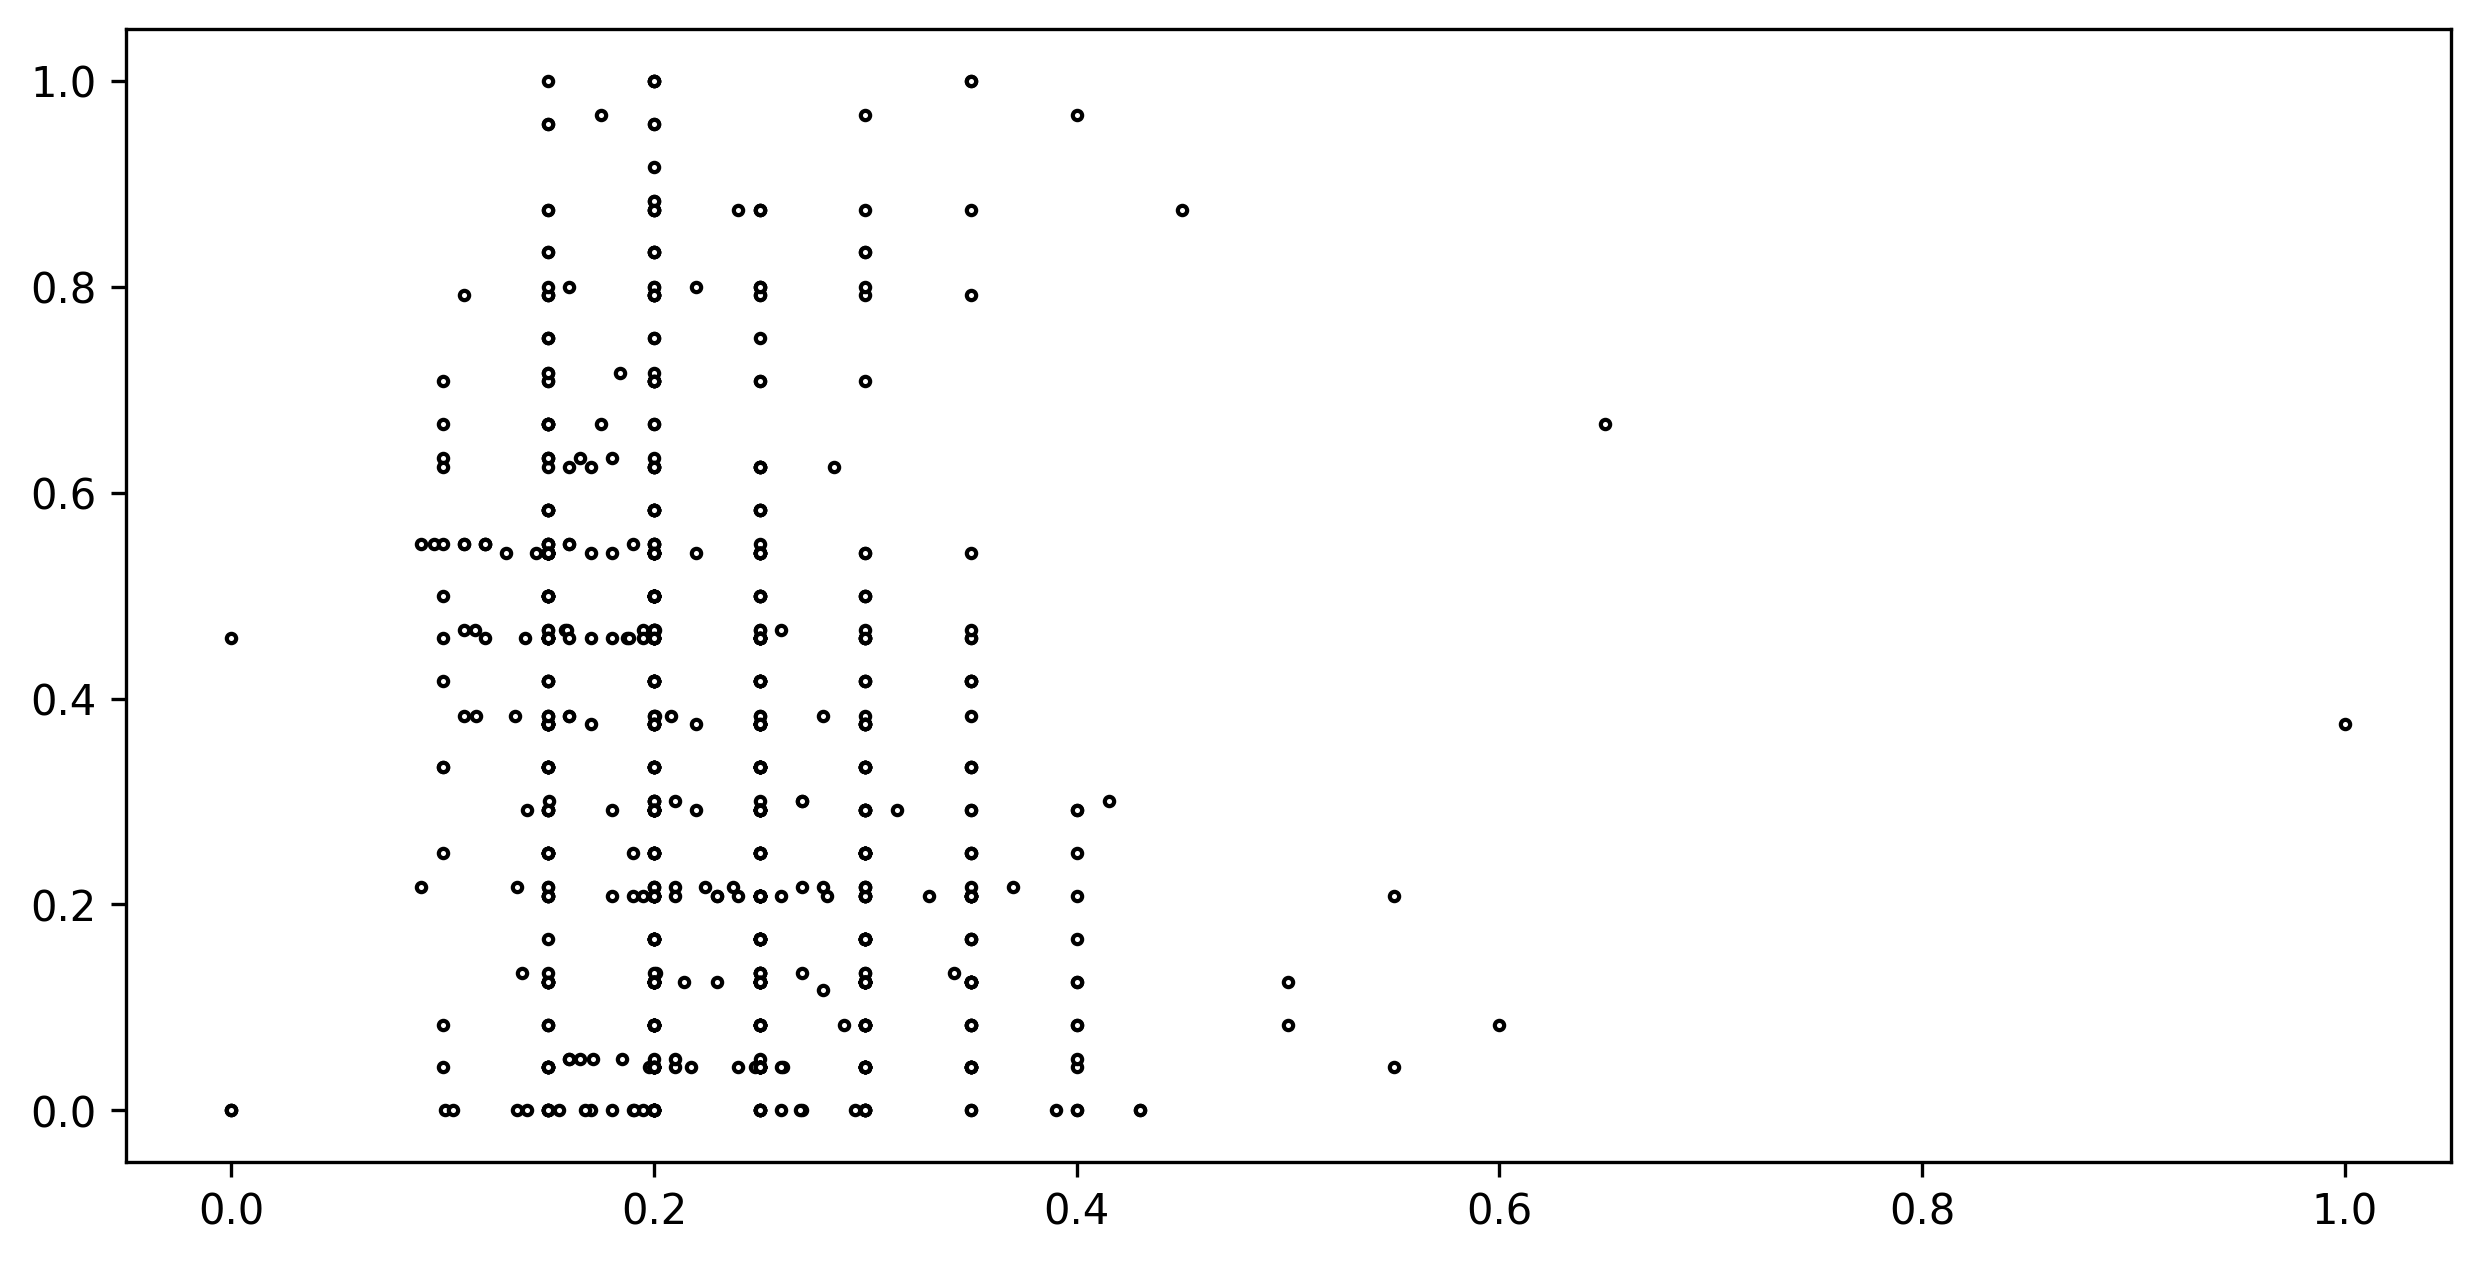

In [15]:
# plot season metadata
plt.scatter(
   season_meta[:, 0], season_meta[:, 1],
   c='white', marker='o',
   edgecolor='black', s=5
)
plt.show()

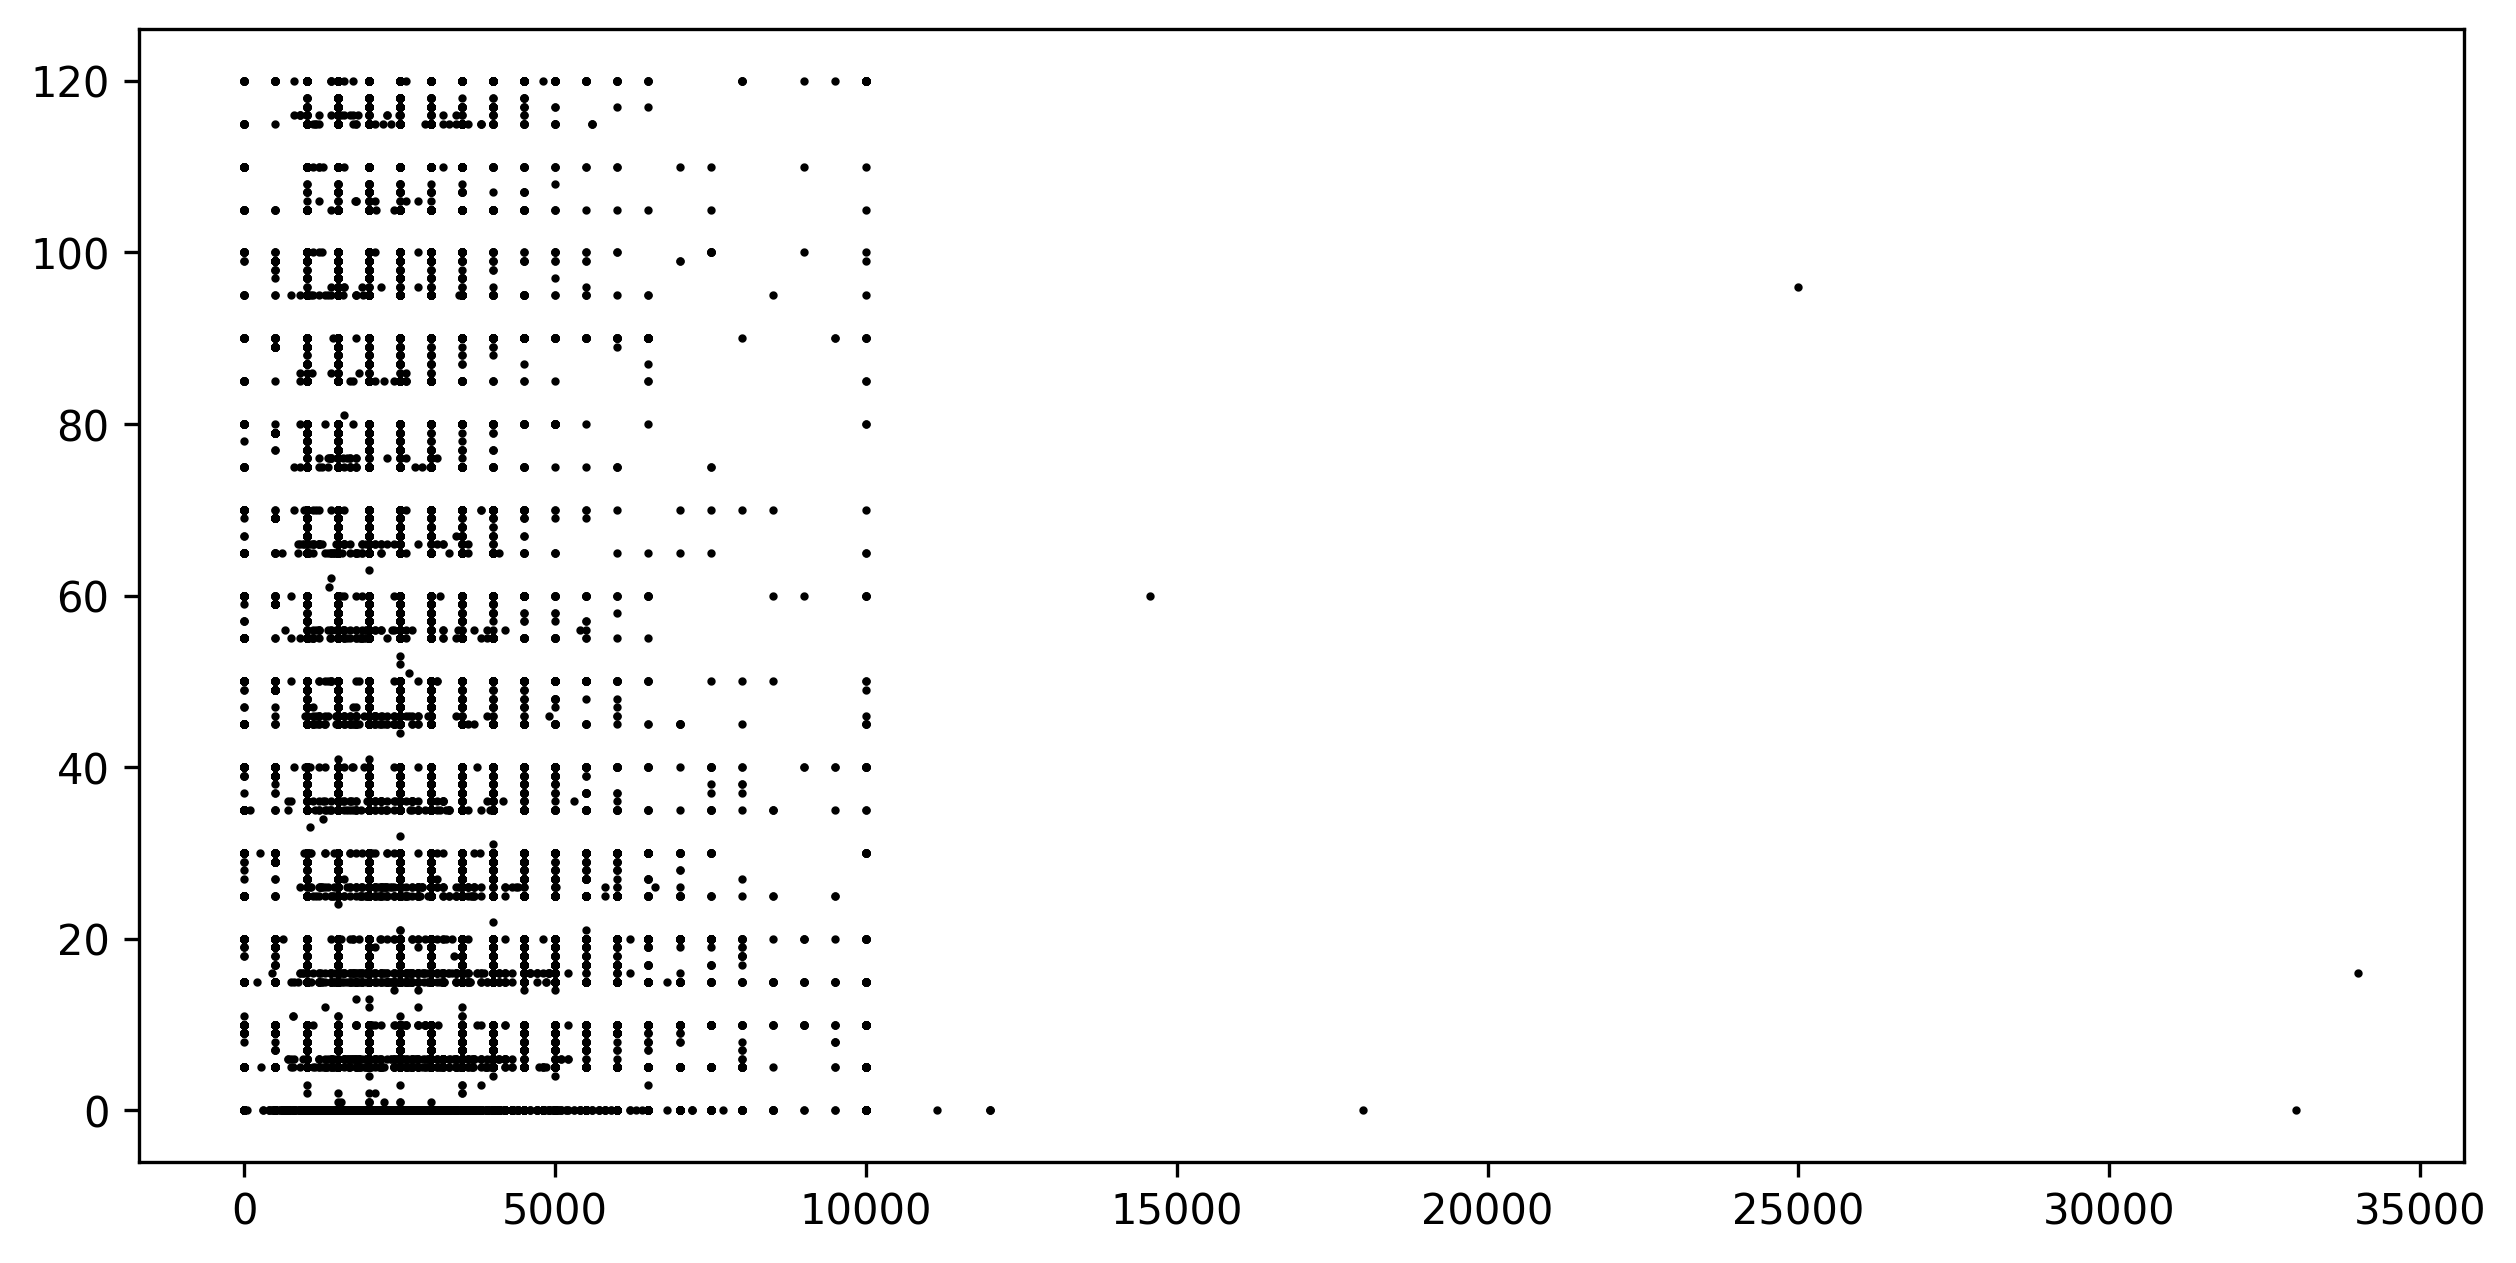

In [16]:
# plot all metadata
plt.scatter(
   meta[:, 1], meta[:, 2],
   c='white', marker='o',
   edgecolor='black', s=1
)
plt.show()

K-means using $k=6$ clusters

In [17]:
K = 6
km = KMeans(
    n_clusters=K, init='random',
    n_init=10, max_iter=300, 
    tol=1e-04, random_state=0
)
y_km = km.fit_predict(season_meta)

In [18]:
km.cluster_centers_

array([[0.18046   , 0.55219048],
       [0.21841881, 0.40305281],
       [0.20331231, 0.06397436],
       [0.34619388, 0.08579932],
       [0.2195119 , 0.82470238],
       [0.24255289, 0.2347037 ]])

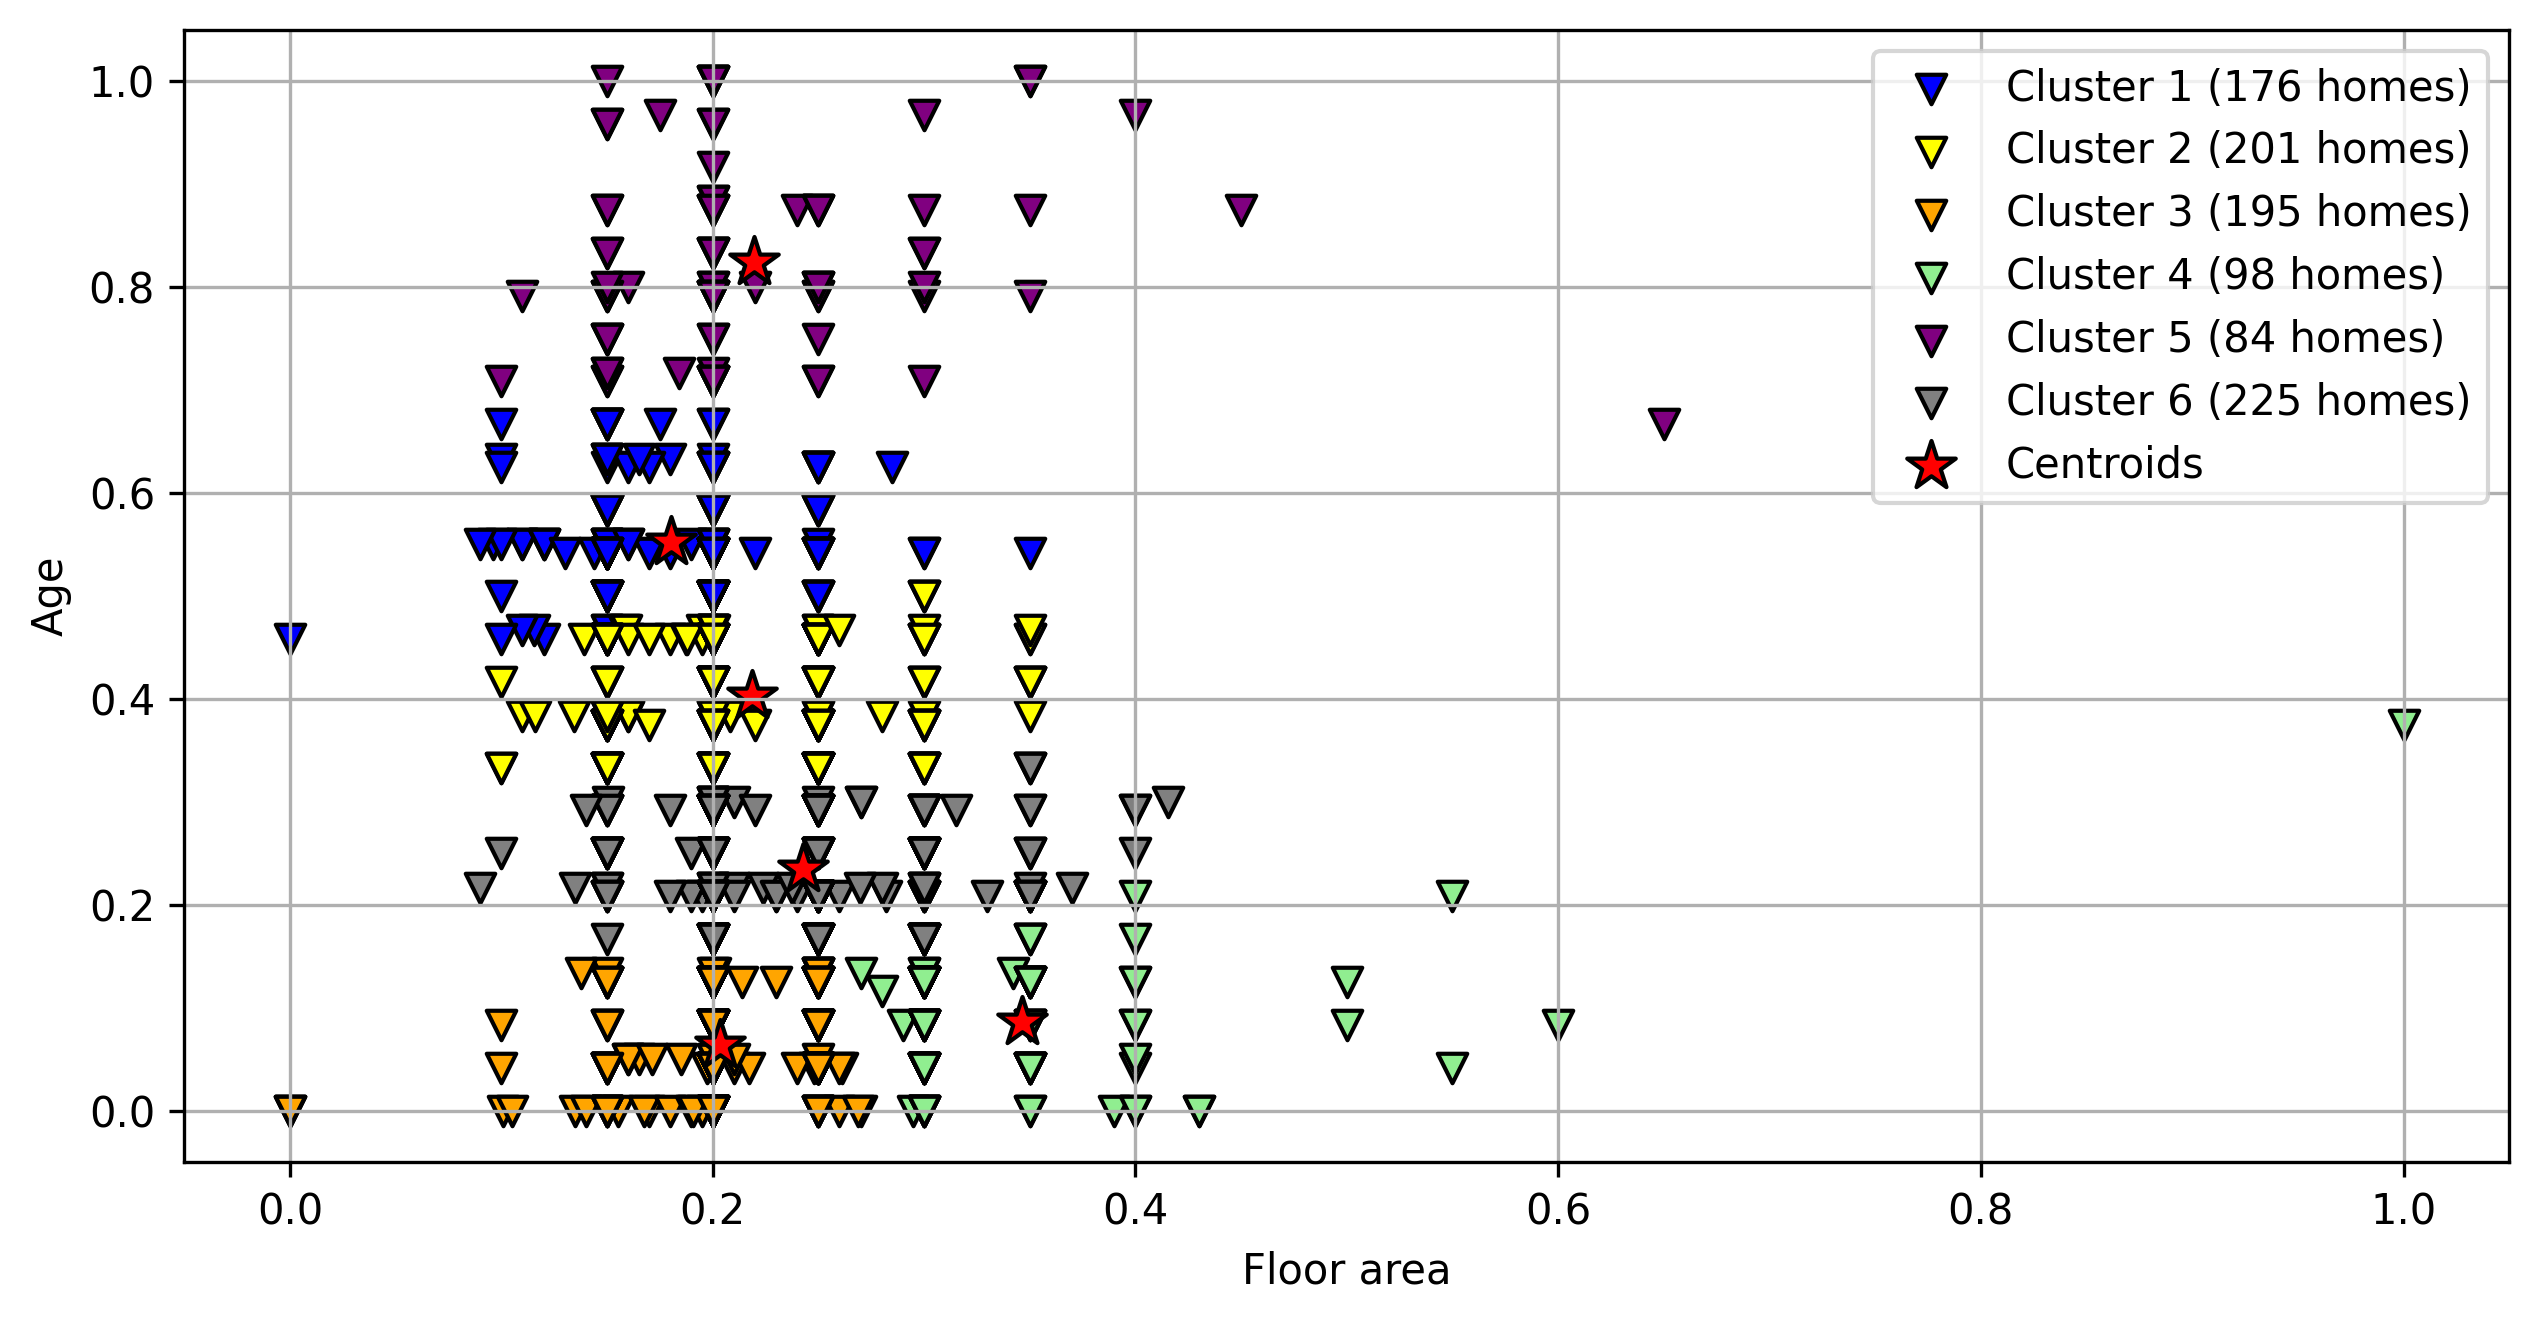

In [19]:
# plot the k clusters
colors = ['blue', 'yellow', 'orange', 'lightgreen', 'purple', 'grey', 'tan', 'pink', 'navy', 'aqua']

season_clusters_ids = {}
for k in range(K):
    season_clusters_ids[k] = season_meta_ids[y_km == k]
    plt.scatter(
        season_meta[y_km == k, 0], season_meta[y_km == k, 1],
        s=50, c=colors[k],
        marker='v', edgecolor='black',
        label= f"Cluster {k+1} ({len(season_clusters_ids[k])} homes)"
    )

# plot the centroids
plt.scatter(
    km.cluster_centers_[:, 0], km.cluster_centers_[:, 1],
    s=150, marker='*',
    c='red', edgecolor='black',
    label='Centroids'
)
plt.rcParams['figure.figsize'] = (6.4, 4.8)
plt.xlabel('Floor area')
plt.ylabel('Age')
plt.legend(scatterpoints=1)
plt.rc('legend', fontsize=4)
plt.grid()
# plt.show()
plt.savefig('temp.pdf')

Select the best value of $k$ by calculating the distortion for a range of number of cluster (the Elbow method)

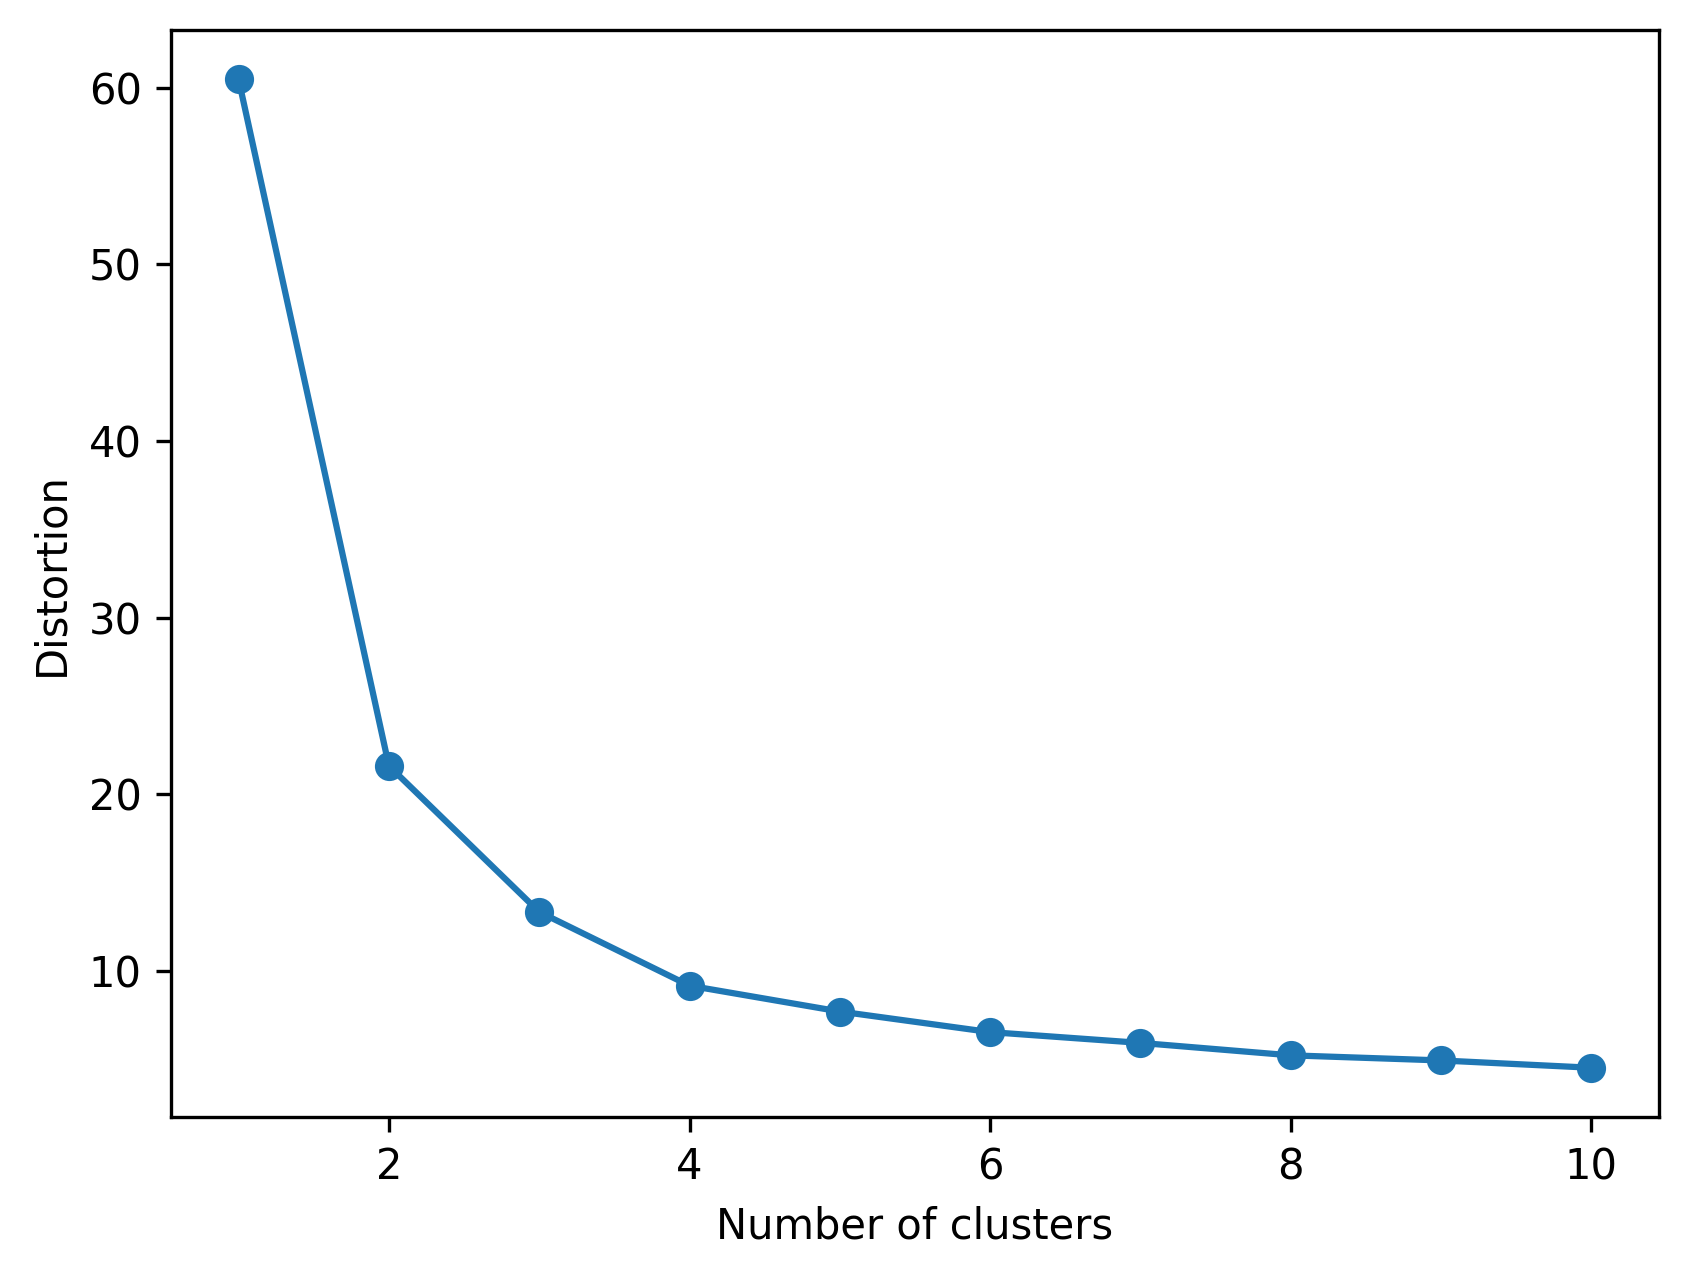

In [20]:
distortions = []
for i in range(1, 11):
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(season_meta)
    distortions.append(km.inertia_)

# plot
plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
# plt.show()
plt.savefig('Elbow.pdf')

In [21]:
summer_clusters = {}
for k, ids in season_clusters_ids.items():
    print(f"Cluster {k} has {len(ids)} homes")
    c = {}
    _, indicies, _ = np.intersect1d(summer['id'], ids, return_indices=True)

    for key, value in summer.items():
        if key == "time":
            c[key] = value
        else:
            c[key] = value[indicies]
        if key == 'id':
            print(f"ID SHAPE: {c[key].shape} over {value.shape}")
    summer_clusters[k] = c
summer_clusters.keys()

Cluster 0 has 176 homes
ID SHAPE: (176,) over (979,)
Cluster 1 has 201 homes
ID SHAPE: (201,) over (979,)
Cluster 2 has 195 homes
ID SHAPE: (195,) over (979,)
Cluster 3 has 98 homes
ID SHAPE: (98,) over (979,)
Cluster 4 has 84 homes
ID SHAPE: (84,) over (979,)
Cluster 5 has 225 homes
ID SHAPE: (225,) over (979,)


dict_keys([0, 1, 2, 3, 4, 5])

### Save cluster files as csv

In [22]:
def clusterToDataFrame(cluster, resample=TIME_ABSTRACTION):
    df = pd.DataFrame()
    df['time'] = np.tile(cluster['time'], len(cluster['id']))
    df = df.set_index('time')
    df.index = pd.to_datetime(df.index, unit='s')

    for key, value in cluster.items():
        if key in DF_CLUSTER_IDX:
            df[key] = value.ravel()
            
    if resample:
        df = df.resample(resample).mean()
        
    df = df.reindex(columns=DF_CLUSTER_IDX)

    return df

In [23]:
clusterToDataFrame(summer_clusters[0])

,in_cool,in_heat,in_hum,out_hum,out_temp,in_temp
time,,,,,,
2017-06-01 00:00:00,73.750000,63.568655,51.741951,73.940341,58.806818,69.830966
2017-06-01 01:00:00,73.705019,63.489583,51.809186,74.894886,58.372159,69.564867
2017-06-01 02:00:00,73.693655,63.475379,51.891572,76.551136,57.539773,69.299716
2017-06-01 03:00:00,73.720170,63.442708,52.007102,78.303977,56.727273,68.927083
2017-06-01 04:00:00,73.745739,63.482481,52.256155,80.147727,56.258523,68.618845
...,...,...,...,...,...,...
2017-08-31 19:00:00,74.868056,67.591383,51.049024,44.896307,77.400568,74.232785
2017-08-31 20:00:00,74.737279,67.669034,50.935395,50.156250,74.147727,73.983411
2017-08-31 21:00:00,74.886837,67.394413,50.922968,54.164773,71.960227,73.670200


In [24]:
for ck, cv in summer_clusters.items():
    cdf = clusterToDataFrame(cv)
    if not os.path.exists(CLUSTERS_DIR):
        os.mkdir(CLUSTERS_DIR)
    cfile = os.path.join(CLUSTERS_DIR, f"cluster_{ck}.csv")
    print(f"Saving cluster {ck} to file: {cfile}...")
    cdf.to_csv (cfile, sep=',')
"DONE."     

Saving cluster 0 to file: data/ecobee/clusters/cluster_0.csv...
Saving cluster 1 to file: data/ecobee/clusters/cluster_1.csv...
Saving cluster 2 to file: data/ecobee/clusters/cluster_2.csv...
Saving cluster 3 to file: data/ecobee/clusters/cluster_3.csv...
Saving cluster 4 to file: data/ecobee/clusters/cluster_4.csv...
Saving cluster 5 to file: data/ecobee/clusters/cluster_5.csv...


'DONE.'

> #### We have 6 clusters of size: 311, 227, 7, 219, 130, 78 homes

### Similarity graph
Similarity graph based on:
- Floor area
- Age

To be added:

- Number of Floors
- City / State

In [ ]:
meta_file = os.path.join(, "meta_data.csv")
df = pd.read_csv(meta_file)# , usecols= META_SIM_COLUMNS
meta = df.to_numpy()
df.head(4)

In [ ]:
_, season_indicies, _ = np.intersect1d(meta[:, 0], winter['id'], return_indices=True)
season_meta = meta[season_indicies][:,1:]
season_meta_ids = meta[season_indicies][:,0]
season_meta

### Building the similarity matrix based on Cosine similarity

In [ ]:
A = season_meta.astype(float)
B = A[0]
similarity_scores = A.dot(B)/ (np.linalg.norm(A, axis=1) * np.linalg.norm(B) + 1e-17) 
similarity_scores

### Set a threshold $\rho$ for peers connection: $W_{ij} \neq 0$

In [ ]:
neighbors = np.where(similarity_scores > 0.999999)
print(f"User ID#0 has {len(neighbors[0])} neighbors:\n{neighbors[0].ravel()}")

----
## Run the RNN blackbox  model  (TODO)

In [ ]:
# todo ...

----
## Run the LSTM blackbox  model

#### Load cluster zero dataset

In [36]:
cluster_file = os.path.join(CLUSTERS_DIR, "cluster_0.csv")
cdata = pd.read_csv(cluster_file, sep=',', index_col='time', parse_dates=True).sort_index()
# cdata.drop(columns=['state'], inplace=True)
cdata

,in_cool,in_heat,in_hum,out_hum,out_temp,in_temp
time,,,,,,
2017-06-01 00:00:00,73.750000,63.568655,51.741951,73.940341,58.806818,69.830966
2017-06-01 01:00:00,73.705019,63.489583,51.809186,74.894886,58.372159,69.564867
2017-06-01 02:00:00,73.693655,63.475379,51.891572,76.551136,57.539773,69.299716
2017-06-01 03:00:00,73.720170,63.442708,52.007102,78.303977,56.727273,68.927083
2017-06-01 04:00:00,73.745739,63.482481,52.256155,80.147727,56.258523,68.618845
...,...,...,...,...,...,...
2017-08-31 19:00:00,74.868056,67.591383,51.049024,44.896307,77.400568,74.232785
2017-08-31 20:00:00,74.737279,67.669034,50.935395,50.156250,74.147727,73.983411
2017-08-31 21:00:00,74.886837,67.394413,50.922968,54.164773,71.960227,73.670200


In [44]:
cdata.describe()

,in_cool,in_heat,in_hum,out_hum,out_temp,in_temp
count,2208.000000,2208.000000,2208.000000,2208.000000,2208.000000,2208.000000
mean,74.787740,65.689045,53.323509,66.499644,71.043526,72.919579
std,0.910330,1.054059,2.152747,12.244455,6.652020,1.659648
min,72.487689,62.228220,47.122159,40.215909,54.750000,67.352509
25%,74.153883,64.931700,51.837935,55.689276,65.924716,72.030227
50%,74.810133,65.789336,53.355824,67.481534,70.281250,73.108546
75%,75.398556,66.457860,54.931463,77.411932,76.520241,74.124645
max,77.111742,68.202178,58.368225,87.772727,86.328125,76.368608


<AxesSubplot:xlabel='time'>

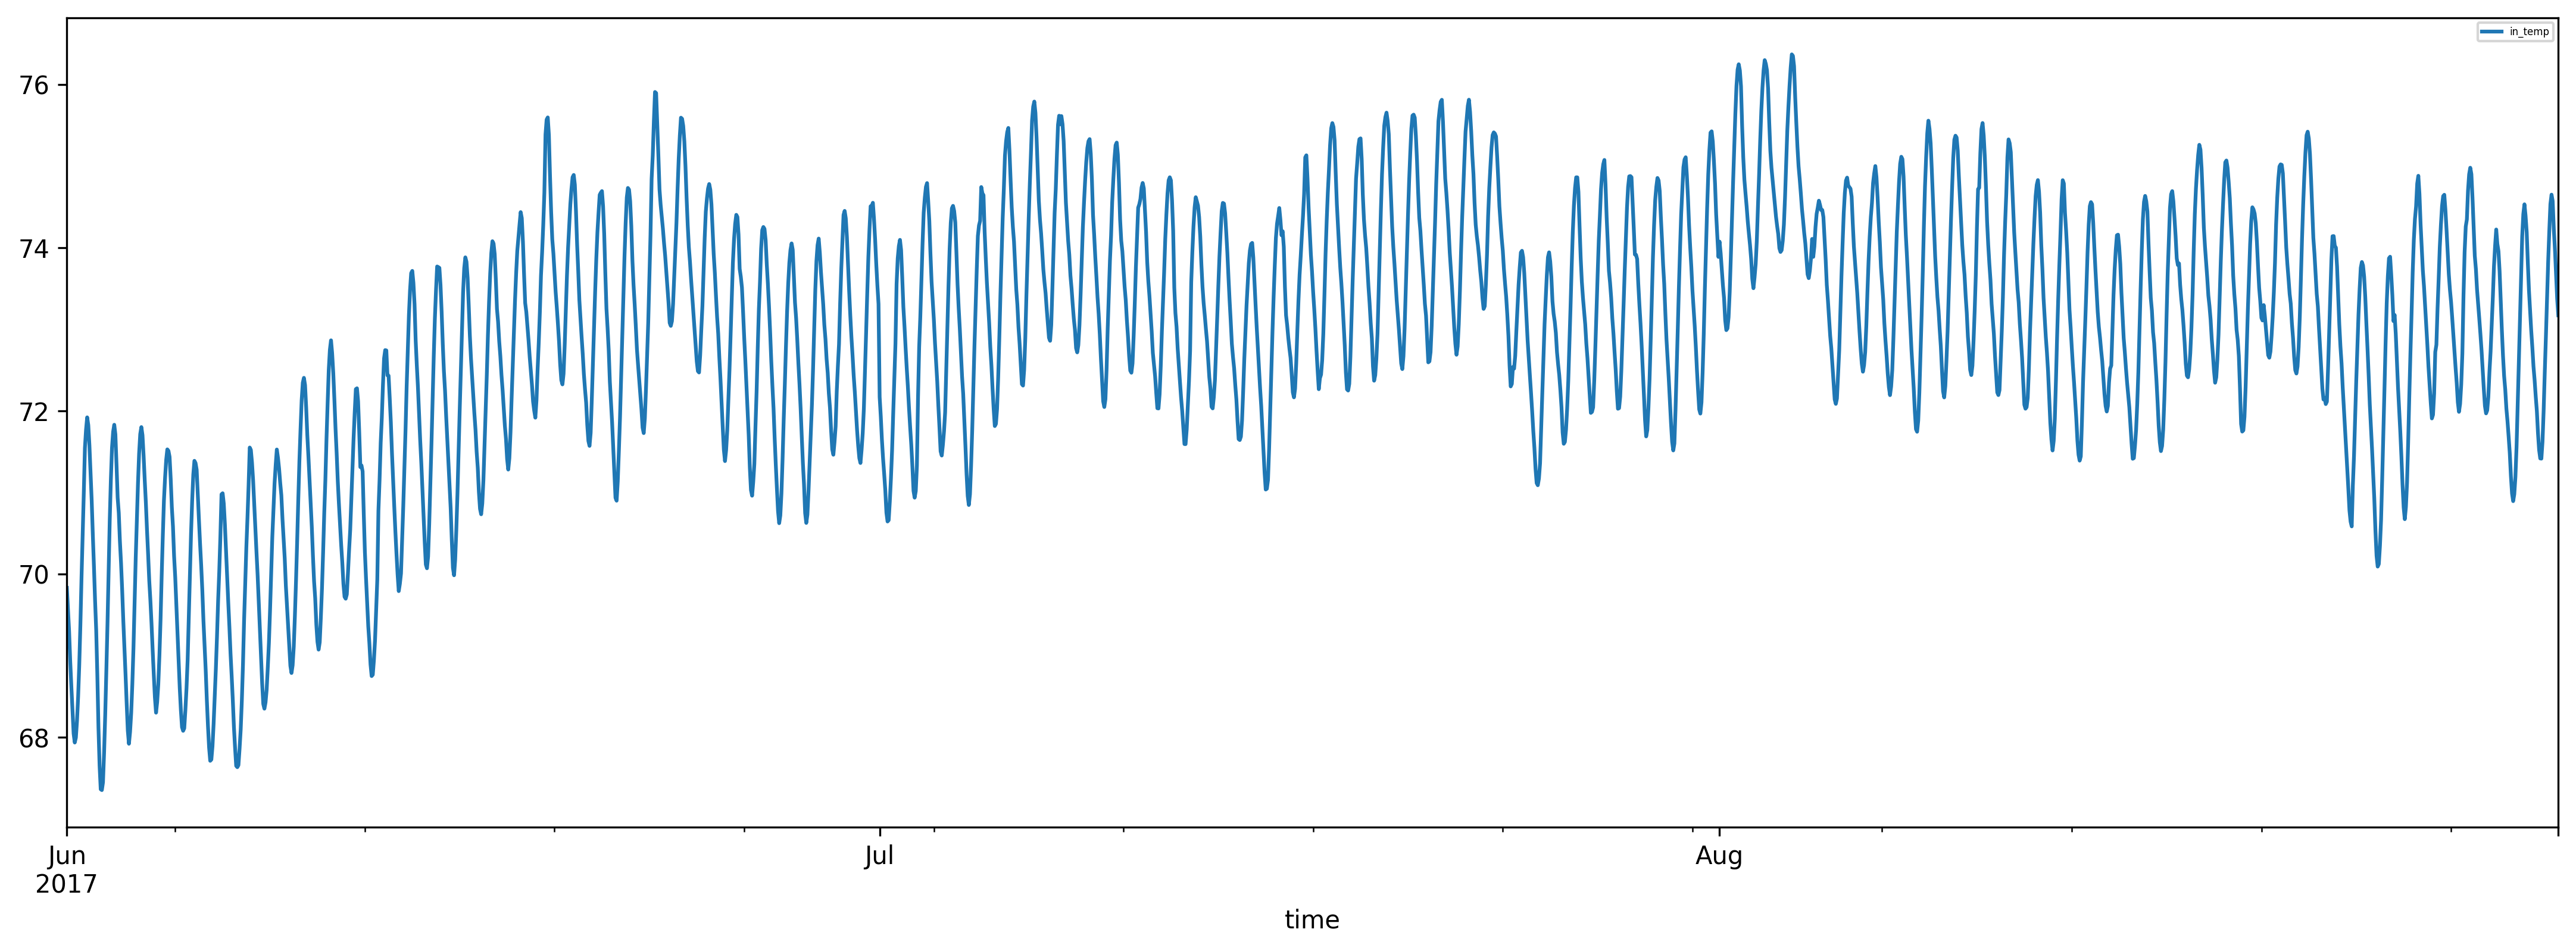

In [45]:
cdata.plot(y='in_temp', kind = 'line', figsize=(18,6))

#### Split data: 75 days for train & 15 days for test 
Breaking date:
- Winter: 2017-02-15 00:00:00
- Summer: 2017-08-15 00:00:00

In [46]:
cdata.columns

Index(['in_cool', 'in_heat', 'in_hum', 'out_hum', 'out_temp', 'in_temp'], dtype='object')

In [47]:
break_date = "2017-08-15"
train = cdata[:break_date]
test = cdata[break_date:].copy()

print(f'Train size : {train.shape}')
print(f'Test size  : {test.shape}')

Train size : (1824, 6)
Test size  : (408, 6)


#### Normalize data

In [48]:
scaler = MinMaxScaler()
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)
scaled_train.shape, scaled_test.shape

((1824, 6), (408, 6))

In [49]:
print(list(train.columns))
print(scaled_train[0])
print(scaled_test[0])

['in_cool', 'in_heat', 'in_hum', 'out_hum', 'out_temp', 'in_temp']
[0.27298792 0.22437981 0.4107918  0.70913978 0.12846925 0.27489234]
[0.42043826 0.46001427 0.68058312 0.81523297 0.39539382 0.62968701]


#### Time series generator

In [50]:
n_input = 24 * 12 # use 24 hours history
n_features = 6
generator = TimeseriesGenerator(scaled_train, scaled_train[:, -1], length=n_input, batch_size=1)
# generator = TimeseriesGenerator(X_train, y_train, length=n_input, batch_size=1)

In [51]:
X,y = generator[0]
print(f'Given X of {len(X.flatten())} sampels x features')
print(f'Predict Y: {y}')

Given X of 1728 sampels x features
Predict Y: [0.4581189]


#### Define LSTM model

In [56]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 100)               42800     
                                                                 
 dense_3 (Dense)             (None, 1)                 101       
                                                                 
Total params: 42,901
Trainable params: 42,901
Non-trainable params: 0
_________________________________________________________________


#### Fit the LSTM model

In [57]:
model.fit(generator,epochs=10)

Epoch 1/10
1536/1536 [==============================] - 67s 43ms/step - loss: 0.0033
Epoch 2/10
1536/1536 [==============================] - 64s 42ms/step - loss: 8.8481e-04
Epoch 3/10
1536/1536 [==============================] - 65s 42ms/step - loss: 5.9822e-04
Epoch 4/10
1536/1536 [==============================] - 65s 42ms/step - loss: 4.4231e-04
Epoch 5/10
1536/1536 [==============================] - 66s 43ms/step - loss: 3.8314e-04
Epoch 6/10
1536/1536 [==============================] - 65s 42ms/step - loss: 3.4343e-04
Epoch 7/10
1536/1536 [==============================] - 65s 42ms/step - loss: 3.2483e-04
Epoch 8/10
1536/1536 [==============================] - 64s 42ms/step - loss: 2.5667e-04
Epoch 9/10
1536/1536 [==============================] - 67s 43ms/step - loss: 2.3995e-04
Epoch 10/10
1536/1536 [==============================] - 66s 43ms/step - loss: 2.1606e-04


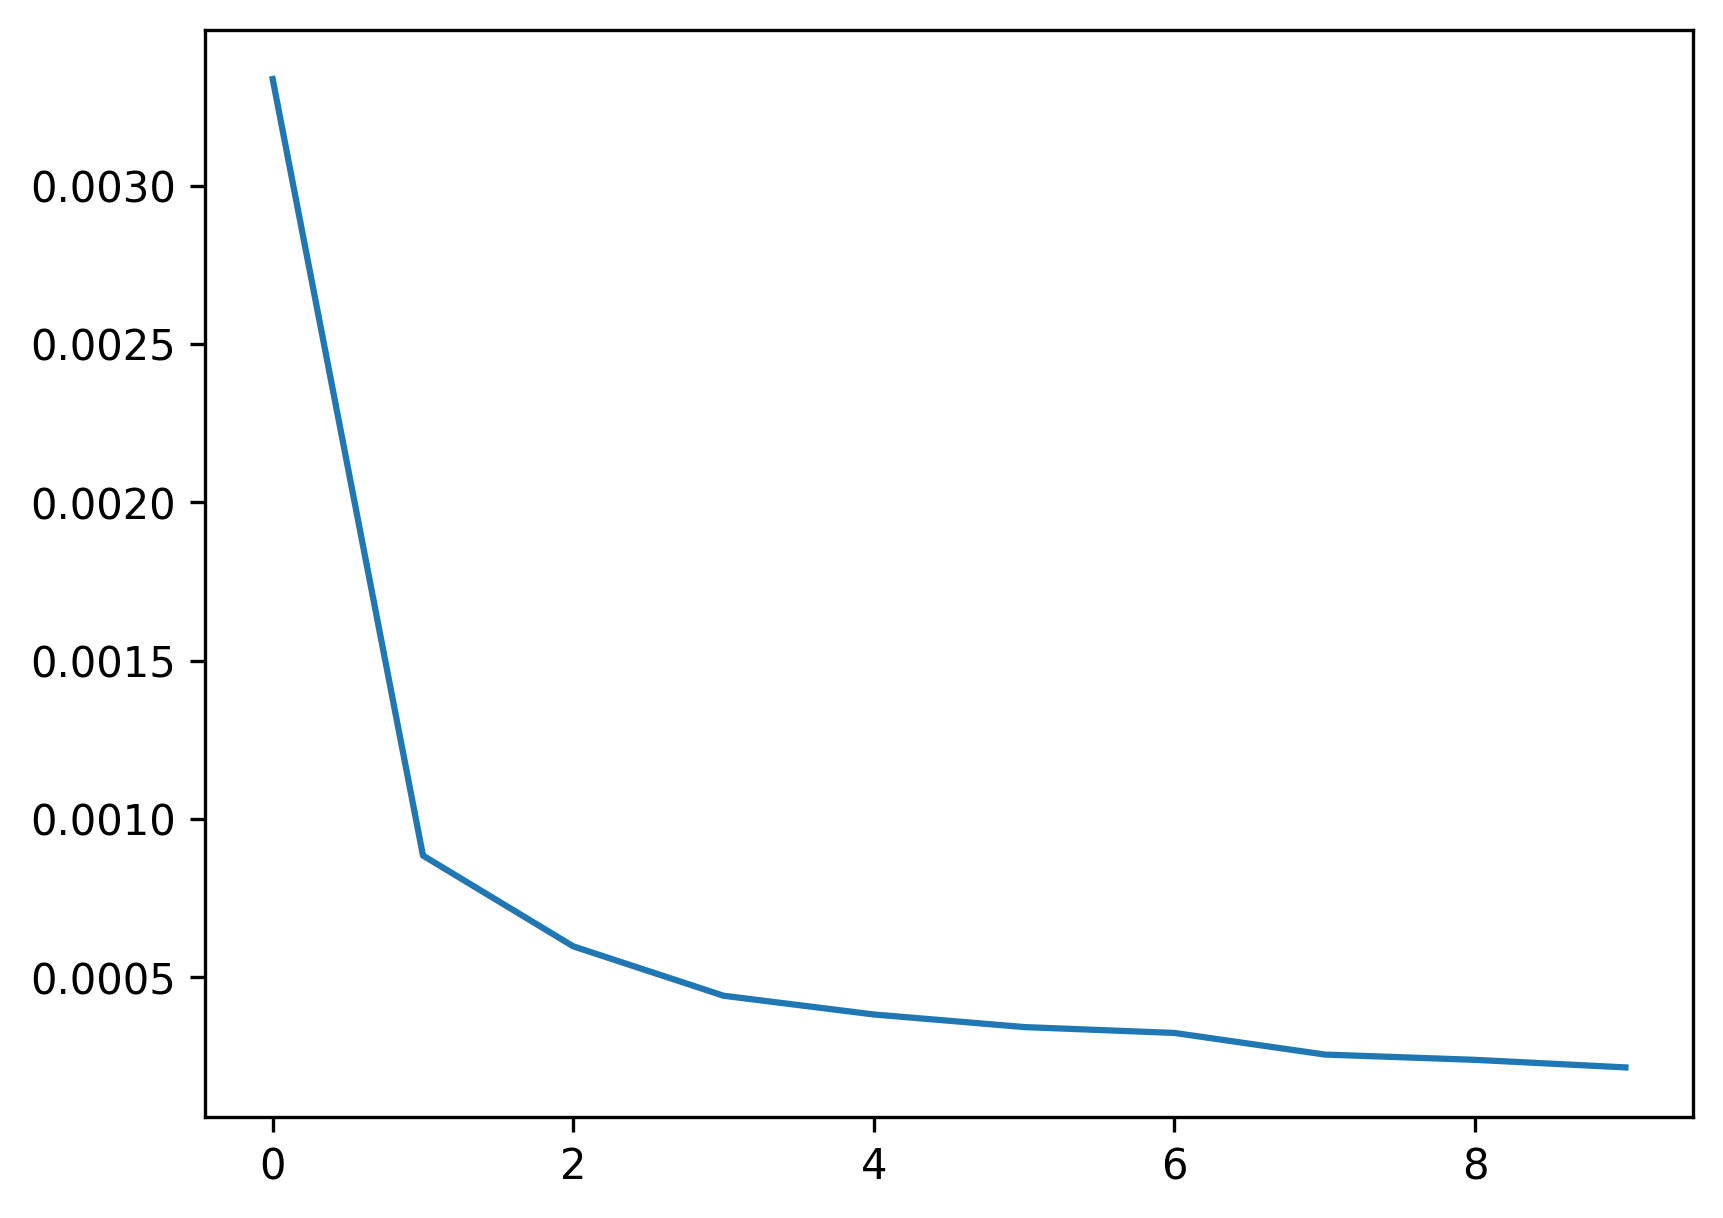

In [58]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [59]:
last_train_batch = scaled_train[-n_input:]
last_train_batch.shape

(288, 6)

In [60]:
last_train_batch = last_train_batch.reshape((1, n_input, n_features))
last_train_batch.shape

(1, 288, 6)

In [61]:
model.predict(last_train_batch)

1/1 [==============================] - 0s 169ms/step


array([[0.57323676]], dtype=float32)

In [62]:
scaled_test[0, -1]

0.6296870076672629

In [63]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i, t in enumerate(scaled_test):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred)
    next_test = copy.deepcopy(t)
    next_test[n_features-1] = current_pred
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[next_test]],axis=1)

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 22ms/step


In [64]:
pred_scaler = MinMaxScaler()
pred_scaler.min_, pred_scaler.scale_, = scaler.min_[0], scaler.scale_[0] 
true_predictions = pred_scaler.inverse_transform(test_predictions)

In [65]:
test_predictions[0]

array([0.57323676], dtype=float32)

In [66]:
true_predictions[0]

array([75.13836659])

In [67]:
test["Predictions"] = true_predictions

In [68]:
test.head(1)

,in_cool,in_heat,in_hum,out_hum,out_temp,in_temp,Predictions
time,,,,,,,
2017-08-15,74.431818,64.976326,54.776042,78.985795,67.235795,73.02983,75.138367


<AxesSubplot:xlabel='time'>

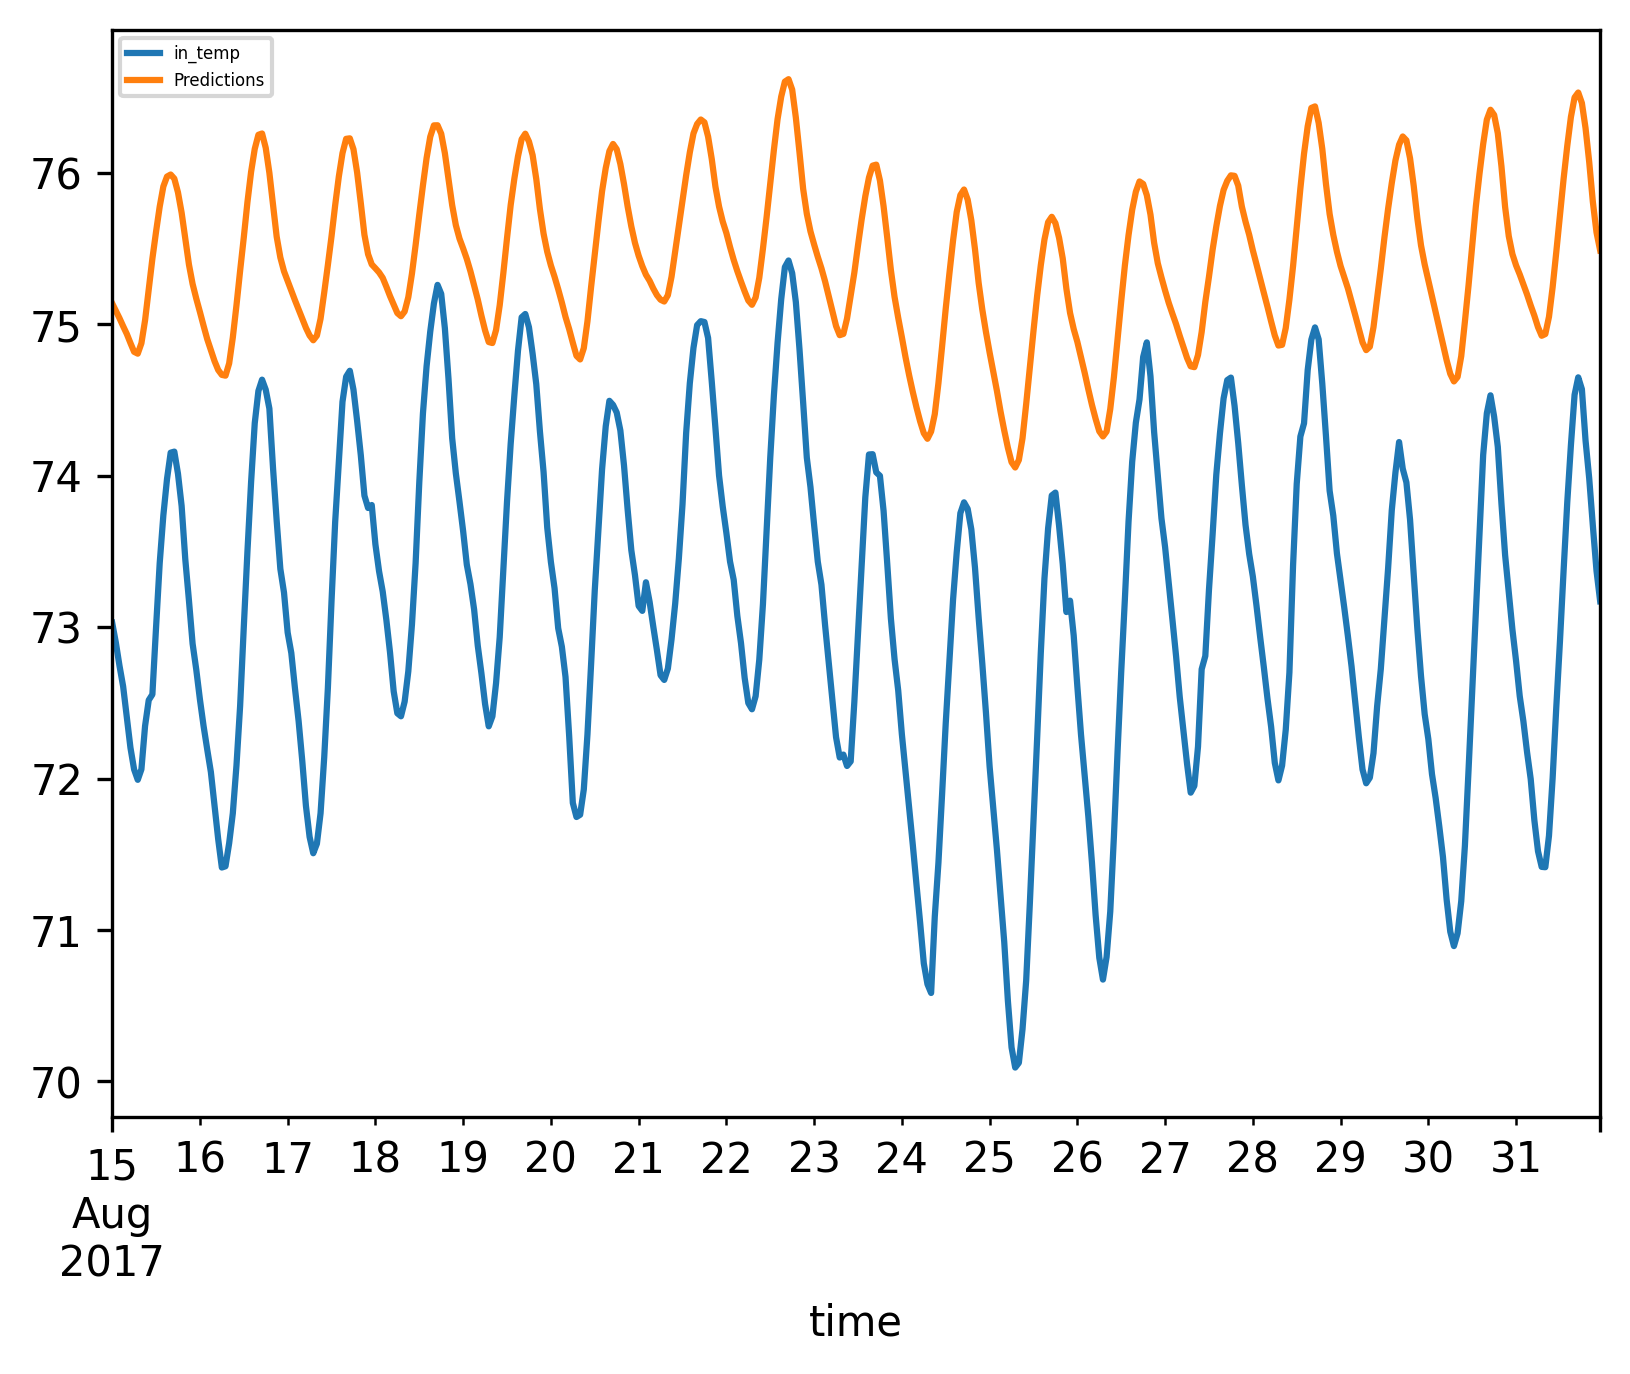

In [78]:
test.plot(y=["in_temp", "Predictions"])

In [76]:
rmse=sqrt(mean_squared_error(test['in_temp'],test['Predictions']))
rmse

2.3908082267735957

---
### Run the BNN-RC model (TODO)

In [ ]:
df_cars = pd.DataFrame([[120000, 11], [250000, 11.5], [175000, 15.8], [350000, 17], [400000, 10]],
                       columns=['odometer_reading', 'fuel_economy'])
df_cars

In [ ]:

scaler = MinMaxScaler()
scaler.fit_transform(df_cars)
df_norm = pd.DataFrame(, columns=df_cars.columns)
df_norm

In [ ]:
scaled_data = abs_scaler.transform(df_cars)
df_scaled = pd.DataFrame(scaled_data, columns=df_cars.columns)
df_scaled

In [ ]:
df_cars.columns

In [ ]:
def FtoC(F):
    # Convert the Fahrenheit into Celsius
    return (5 / 9) * (F - 32)

def CtoF(C):
    # Convert the Fahrenheit into Celsius
    return C * 1.8 + 32